In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_pandas, tqdm_notebook
import datetime
import pymongo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import statistics as stat

client = pymongo.MongoClient()
db = client['Data']
pd.options.plotting.backend = "matplotlib"
tqdm.pandas(desc="progress-bar")

plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
def load_mongo(col):
    df = pd.DataFrame(list(db[col].find({})))
    df.drop('_id', axis=1, inplace=True)
    df.set_index('日期', inplace=True)
    limit = set(sector).intersection(set(tcri)).intersection(df.columns)
    return df.loc[:, limit]


def max_draw_down(profit):
    mdd = 0
    dd = 0
    mp = 0
    loss = 0
    dt = None
    for i in range(len(profit)):
        if profit[i] > mp:
            mp = profit[i]
            dd = 0
        elif profit[i] < mp:
            loss = (profit[i] - mp)
            if loss < dd:
                dd = loss
        if dd < mdd:
            mdd = dd
            dt = profit.index[i]
    return mdd, dt


def java_plot():
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    avg = bs.sum(axis=1).mean()
    twa_profit = (twa_close['加權指數'].pct_change().shift(-2)*avg).cumsum()#*bs.sum(axis=1)).cumsum()
    avg_profit = (avgadjclose.shift(-2)*avg).cumsum()#*bs.sum(axis=1)).cumsum()
    fig.add_trace(
        go.Scatter(y=twa_profit, x=twa_profit.index ,name='加權指數'),
        secondary_y=False
    )
    fig.add_trace(
        go.Scatter(y=avg_profit, x=avg_profit.index, name='平權指數'),
        secondary_y=False
    )
    bs_s = bs.sum(axis=1)
    bs_s.name = 'bs'
    fig.add_trace(
        go.Scatter(y=p, x=bs.index, name='損益'),
        secondary_y=False
    )
    fig.add_trace(
        go.Scatter(y=bs_s, x=bs.index, name='持股檔數'),
        secondary_y=True
    )
    fig.update_layout(
        title='策略損益與加權比較圖',
        xaxis_title='日期',
        yaxis_title='策略損益、加權指數與持股檔數',
        autosize=False,
        width=1400,
        height=820,
        margin=dict(
            l=50,
            r=10,
            b=100,
            t=100,
            pad=4
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.7
        )
    )
    fig.show()

    
def java_plot_daily(title=''):
    bs_daily = copy.deepcopy(adjopen_daily)
    bs_daily.iloc[:] = np.nan
    bs_daily.loc[bs.index, :] = bs
    bs_daily = bs_daily.fillna(method='ffill').fillna(0)
    bs_daily.to_csv(r'D:\BQuant Hackathon\ForBqnt.csv', encoding='big5')
    #bs_daily.loc[((bs_daily.index.month==7) | (bs_daily.index.month==8) | (bs_daily.index.month==9)).index] = 0
    p_daily = (((bs_daily * profit_daily).progress_apply(prodprofit, axis=0).sum(axis=1) - (bs_daily - bs_daily.shift(1)).abs().sum(axis=1) * 0.01) / bs_daily.sum(axis=1).replace(0, 1)).cumsum()
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    avg = bs_daily.sum(axis=1).mean()
    twa_profit = (twa_close_daily['加權指數'].pct_change().shift(-2)).cumsum()#*bs.sum(axis=1)).cumsum()
    avg_profit = (avgadjclose_daily.shift(-2)).cumsum()#*bs.sum(axis=1)).cumsum()
    fig.add_trace(
        go.Scatter(y=twa_profit, x=twa_profit.index ,name='加權指數'),
        secondary_y=False
    )
    fig.add_trace(
        go.Scatter(y=avg_profit, x=avg_profit.index, name='平權指數'),
        secondary_y=False
    )
    bs_s = bs_daily.sum(axis=1)
    bs_s.name = 'bs'
    fig.add_trace(
        go.Scatter(y=p_daily, x=p_daily.index, name='損益'),
        secondary_y=False
    )
    fig.add_trace(
        go.Scatter(y=bs_s, x=bs_daily.index, name='持股檔數'),
        secondary_y=True
    )
    fig.add_trace(
        go.Scatter(y=asr1, x=asr1.index, name='ASharpe Ratio'),
        secondary_y=True
    )
    fig.update_layout(
        title=title,
        xaxis_title='日期',
        yaxis_title='策略損益、加權指數與持股檔數',
        autosize=False,
        width=1400,
        height=820,
        margin=dict(
            l=50,
            r=10,
            b=100,
            t=100,
            pad=4
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.7
        )
    )
    fig.show()

    
def capital_cats(dstore):
    cap_reserve = list(filter(lambda x : x < lb, dstore))
    cap_generate = list(filter(lambda x : x >= ub, dstore))
    cap_maintain = list(filter(lambda x : x >= lb and x < ub, dstore))

    rc=len(cap_reserve); 
    try: 
        rave= stat.mean(cap_reserve) 
    except: 
        rave=0
    mc=len(cap_maintain); 
    try: 
        mave=stat.mean(cap_maintain) 
    except: 
        mave=0
    gc=len(cap_generate); 
    try: 
        gave=stat.mean(cap_generate) 
    except: 
        gave=0
    gRR=(gc/(rc+mc+gc))*gave
    rRR=(rc/(rc+mc+gc))*rave
    mBuf=lambda x: -x if x < 0 else (x if x > 0 else 0)
    mSignedBuf = mBuf((mc/(rc+mc+gc))*mave)

    
    try:
        asr = gRR/abs(rRR) + mSignedBuf
    except:
        asr = mSignedBuf
    return asr


def prodprofit(series):
    cum = 1
    cum1 = 1
    name = series.name
    for i in range(1, len(series)):
        idx = series.index[i]
        if series[i] != 0:
            cum1 = cum
            cum = 1 * cum * (series.iloc[i] + 1)
            series.iloc[i] = cum - cum1
        else:
            cum = 1
            cum1 = 1
    return series

In [3]:
db_map = pd.DataFrame(list(db['產業名稱'].find({}))).drop('_id', axis=1)
#db_map[:, '股票名稱'] = db_map[:, '股票名稱'].str.replace('\*', '')
stock_map = dict(zip(db_map['股票名稱'], db_map['股票代號']))
sector_map = dict(zip(db_map['股票名稱'], db_map['產業名稱']))
tcri = pd.DataFrame(list(db['TCRI'].find({}))).drop('_id', axis=1)['股票名稱']
sector = db_map['股票名稱']

ServerSelectionTimeoutError: localhost:27017: [WinError 10061] 無法連線，因為目標電腦拒絕連線。, Timeout: 30s, Topology Description: <TopologyDescription id: 62f1af1914e0bd985c9d6901, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [WinError 10061] 無法連線，因為目標電腦拒絕連線。')>]>

In [4]:
'''
平權指數
'''

def keypoint(series):
    # init
    data = series.dropna()
    name = data.name
    hold = 0
    index = data.index
    for i in range(2, len(data)):
        idx = index[i]
        idx1 = index[i-1]
        idx2 = index[i-2]
        c = adjclose.loc[idx, name]
        c1 = adjclose.loc[idx1, name]
        l = adjlow.loc[idx, name]
        l1 = adjlow.loc[idx1, name]
        ma5 = adjclose_ma5.loc[idx, name]
        ma10 = adjclose_ma10.loc[idx, name]
        ma20 = adjclose_ma20.loc[idx, name]
        ma60 = adjclose_ma60.loc[idx, name]
        invest1 = invest.loc[idx, name]
        try:
            b = book.loc[idx, name]
        except:
            b = 3001
        v = volume.loc[idx, name]
        sr = asr.loc[idx, name]
        sr1 = asr1.loc[idx]
        sr10 = asr10.loc[idx]
        pc = pct.loc[idx]
        pc_ = pct_.loc[idx]
        out = 0
        if (bs.loc[idx1, name] == 0):
            # 進場
            if (sr >= sr1) & (sr1 > 0) & (v > 250000) & (ma5 > ma20) & (invest1 > 3):
                bs.loc[idx, name] = 1
                entry.loc[idx, name] = c
                entry_date.loc[idx, name] = idx
                entry_type.loc[idx, name] = 1
                entry_time.loc[idx, name] = 1

        if bs.loc[idx1, name] >= 1:
            hold += 1
            entry.loc[idx, name] = entry.loc[idx1, name]
            entry_date.loc[idx, name] = entry_date.loc[idx1, name]
            entry_type.loc[idx, name] = entry_type.loc[idx1, name]
            entry_time.loc[idx, name] = entry_time.loc[idx1, name] + 1

            #if (sr < sr1):
            if (ma5 < ma10) & (sr < sr1) & (c < c1):
                bs.loc[idx, name] = 0
                hold_list.append(hold)
                exit_list.append(1)
                hold = 0
          
            else: # 未出場則延續上一根
                bs.loc[idx, name] = bs.loc[idx1, name]

    return series



progress-bar: 379312it [01:02, 6064.11it/s]


End Time: 2022-04-07 08:46:58


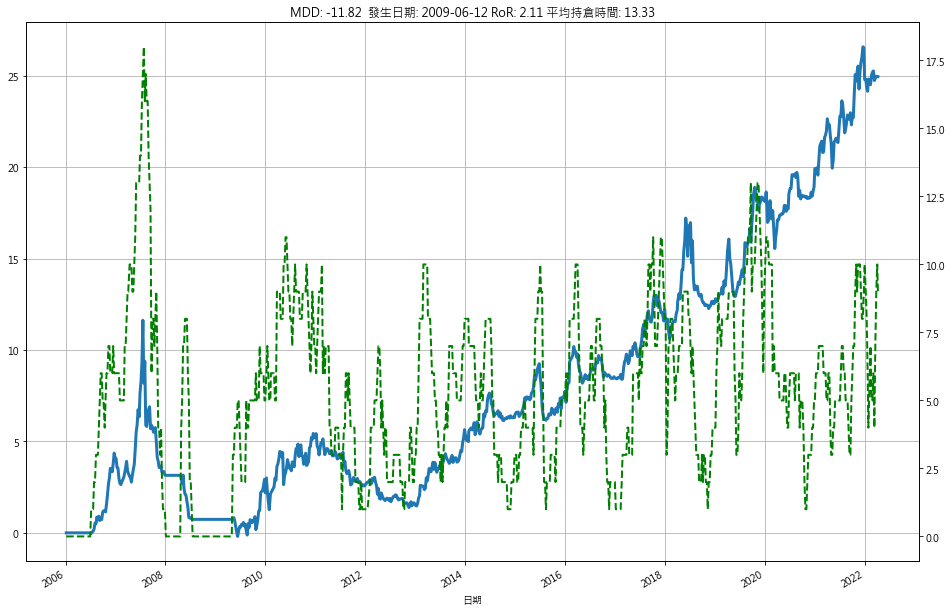

-----------------------------------------------------------------------------------------------------------------------------------------------


In [5]:
# app
change = 'ASharpe'
hold_list = []
exit_list = []
bs_list = []
parameter_list = []
profit_list = []
entry_list = []
entry_date_list = []
entry_type_list = []

#for z in set(sector_map.values()):
#sector = db_map[db_map['產業名稱'] == z]['股票名稱']
    #sector = db_map['股票名稱']
sector = pd.DataFrame([sector_map]).T[pd.DataFrame([sector_map]).T[0].str.contains('電子')].index
close = load_mongo('收盤價')
adjopen = load_mongo('調整開盤價').groupby(pd.Grouper(freq='1W')).head(1)
adjclose = load_mongo('調整收盤價').groupby(pd.Grouper(freq='1W')).tail(1)
adjopen.index = adjclose.index
adjlow = load_mongo('調整最低價').rolling(5).min().groupby(pd.Grouper(freq='1W')).tail(1)
adjlow.index = adjclose.index
invest = load_mongo('投信持股比率')
#adjlow.index = adjclose.index
avgadjclose = adjclose.pct_change().mean(axis=1)
adjopen_daily = load_mongo('調整開盤價')
profit_daily = adjopen_daily.pct_change().shift(-2)
avgadjclose_daily = load_mongo('調整收盤價').pct_change().mean(axis=1)
lb = 0.00; ub = 0.3
pct = adjclose.pct_change()[adjclose.pct_change()>0].quantile(.999, axis=1)#.rolling(20).mean()
pct_ = adjclose.pct_change()[adjclose.pct_change()<=0].quantile(.001, axis=1)#.rolling(20).mean()
asr = adjclose.pct_change().rolling(5).progress_apply(func=capital_cats).fillna(0)
asr1 = asr.quantile(.99, axis=1)
asr10 = asr.quantile(.25, axis=1)
adjopen.index = adjclose.index
book = load_mongo('股本').groupby(pd.Grouper(freq='1W')).tail(1)
twa_close = pd.DataFrame(list(db['指數調整收盤價'].find({}))).drop('_id', axis=1)
twa_close.set_index('日期', inplace=True)
twa_close_daily = copy.deepcopy(twa_close)
twa_close = twa_close.groupby(pd.Grouper(freq='1W')).tail(1)
volume = load_mongo('成交金額').rolling(5).sum().groupby(pd.Grouper(freq='1W')).tail(1)
# 指標

adjclose_ma5 = adjclose.rolling(5).mean()
adjclose_ma10 = adjclose.rolling(10).mean()
adjclose_ma20 = adjclose.rolling(20).mean()
adjclose_ma60 = adjclose.rolling(60).mean()
# 設定、清空初始值
bs = copy.deepcopy(adjclose)
entry = copy.deepcopy(adjclose)
entry_date = copy.deepcopy(adjclose)
entry_type = copy.deepcopy(adjclose)
entry_time = copy.deepcopy(adjclose)
bs.iloc[:] = 0
entry_date.iloc[:] = ''
entry_type.iloc[:] = 0
entry_time.iloc[:] = 0

profit = adjopen.pct_change().shift(-2)# adjopen.shift(-2)/adjopen.shift(-1) - 1
trend = adjclose.apply(func=keypoint, axis=0)

print('End Time: {}'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

p = ((bs * profit).apply(prodprofit, axis=0).sum(axis=1).cumsum() - (bs - bs.shift(1)).abs().sum(axis=1).cumsum() * 0.01)
mdd, mddt = max_draw_down(p)
ror = -p.iloc[-1] / mdd

fig, ax = plt.subplots()
ax2 = ax.twinx()
p.plot(ax=ax, title='MDD: {:.2f}  發生日期: {} RoR: {:.2f} 平均持倉時間: {:.2f}'.format(mdd, mddt.strftime('%Y-%m-%d'), ror, np.mean(hold_list)), figsize=(16,11), linewidth=3, grid=True)
bs.sum(axis=1).plot(ax=ax2, color='green', style='--', linewidth=2)
plt.show()
fig.savefig(change+' MDD {:.2f} RoR {:.2f}'.format(mdd, ror)+'.png')


bs_list.append(bs)
profit_list.append(profit)
entry_list.append(entry)
entry_date_list.append(entry_date)
entry_type_list.append(entry_type)

print('-----------------------------------------------------------------------------------------------------------------------------------------------')


<AxesSubplot:xlabel='日期'>

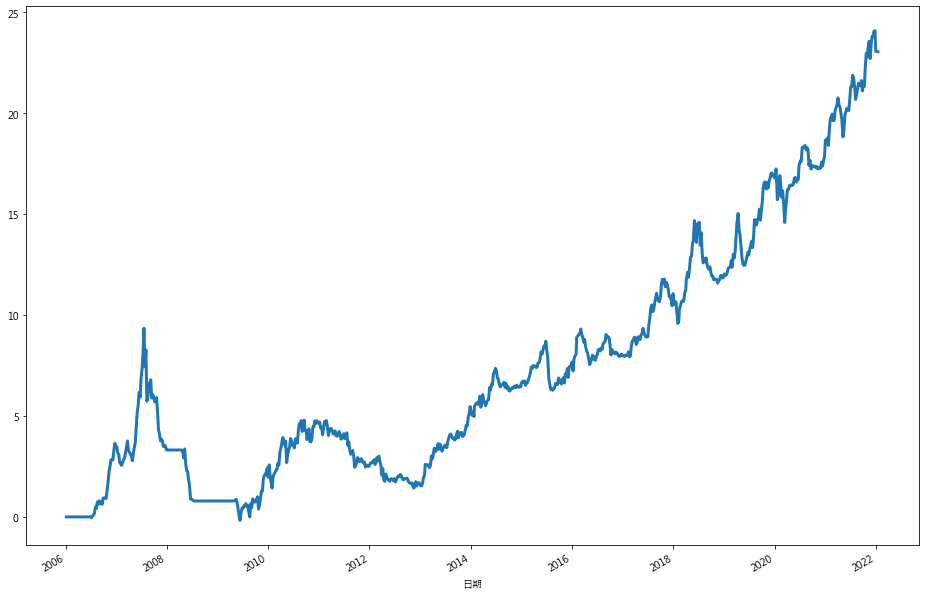

In [49]:
((bs * profit).sum(axis=1).cumsum() - (bs - bs.shift(1)).abs().sum(axis=1).cumsum() * 0.01).plot(figsize=(16, 11), linewidth=3)

In [6]:
bs_std = copy.deepcopy(bs)
bs_std.iloc[:] = 0
bs_std1 = copy.deepcopy(bs)
bs_std1.iloc[:] = 0
bs_std2 = copy.deepcopy(bs)
bs_std2.iloc[:] = 0
profit_std = profit.rolling(10).std().shift(1)
profit_shift = profit.shift(1)
#t = 0
for i in bs.iterrows():
    #t += 1
    mean = profit_shift.loc[i[0]].std()
    profit_std.loc[i[0], i[1][i[1] == 1].index]
    std_ = profit_std.loc[i[0], i[1][i[1] == 1].index] \
    [profit_std.loc[i[0], i[1][i[1] == 1].index] < 0.04]#profit_std.loc[i[0], i[1][i[1] == 1].index].quantile(.8)]
    std__ = profit_std.loc[i[0], i[1][i[1] == 1].index] \
    [profit_std.loc[i[0], i[1][i[1] == 1].index] >= 0.075]#profit_std.loc[i[0], i[1][i[1] == 1].index].quantile(.8)]
    std___ = profit_std.loc[i[0], i[1][i[1] == 1].index] \
    [profit_std.loc[i[0], i[1][i[1] == 1].index].between(0.04, 0.075)]#profit_std.loc[i[0], i[1][i[1] == 1].index].quantile(.8)]    
    
    bs_std.loc[std_.name, std_.index] = 1
    bs_std1.loc[std__.name, std__.index] = 1
    bs_std2.loc[std___.name, std___.index] = 1
    #print(profit_std.loc[i[0], i[1][i[1] == 1].index][profit_std.loc[i[0], i[1][i[1] == 1].index] < 0.04])
    #if t > 30:
    #    break

<AxesSubplot:xlabel='日期'>

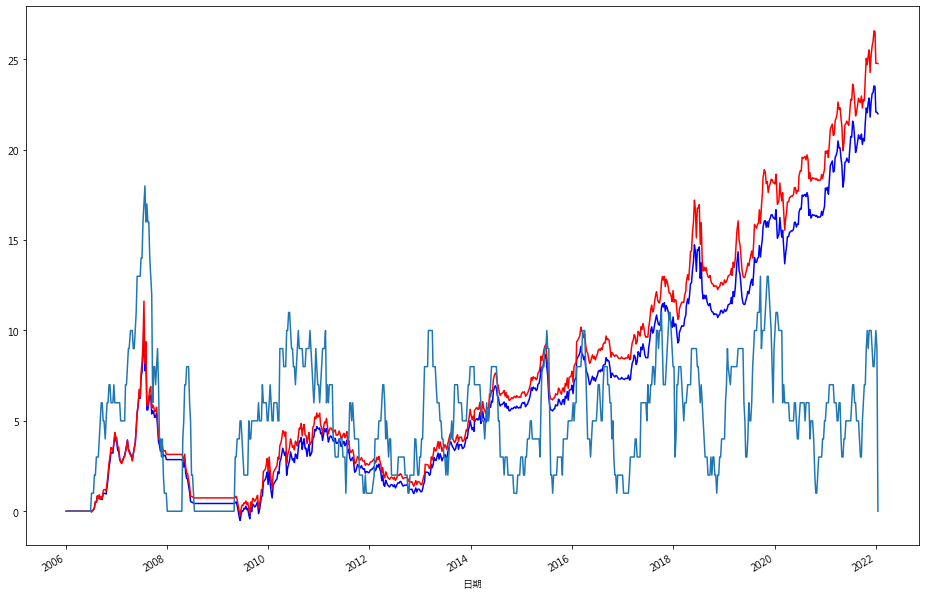

In [46]:
a = 1
b = 1
c = 1
bs_sum2 = (bs_std*a + bs_std1*b + bs_std2*c)
bs_sum3 = (bs_std*1.5 + bs_std1*1.5 + bs_std2*0)

r2 = ((bs_std * profit).apply(prodprofit, axis=0).sum(axis=1).cumsum()*a \
+(bs_std1 * profit).apply(prodprofit, axis=0).sum(axis=1).cumsum()*b \
+(bs_std2 * profit).apply(prodprofit, axis=0).sum(axis=1).cumsum()*c) - ((bs_sum2 - bs_sum2.shift(1)).abs().sum(axis=1) * 0.01).cumsum()#.plot(figsize=(16, 11), color='blue')

#r3 = ((bs_std * profit).apply(prodprofit, axis=0).sum(axis=1).cumsum()*1 \
#+(bs_std1 * profit).apply(prodprofit, axis=0).sum(axis=1).cumsum()*1 \
#+(bs_std2 * profit).apply(prodprofit, axis=0).sum(axis=1).cumsum()*1) - ((bs_sum3.sum(axis=1) - bs_sum3.sum(axis=1).shift(1)).abs() * 0.01).cumsum()
r2.plot(figsize=(16, 11), color='blue')
p.plot(figsize=(16, 11), color='red')
bs_sum2.sum(axis=1).plot()
#bs_sum3.sum(axis=1).plot()

<AxesSubplot:xlabel='日期'>

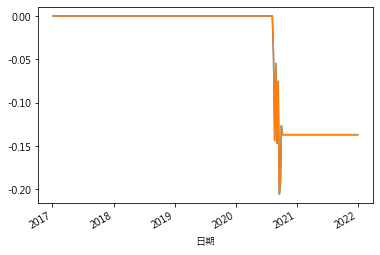

In [38]:
((bs_std2 + bs_std1) * profit)['2017':].apply(prodprofit, axis=0)['南電'].cumsum().plot()
(bs * profit)['2017':].apply(prodprofit, axis=0)['南電'].cumsum().plot()

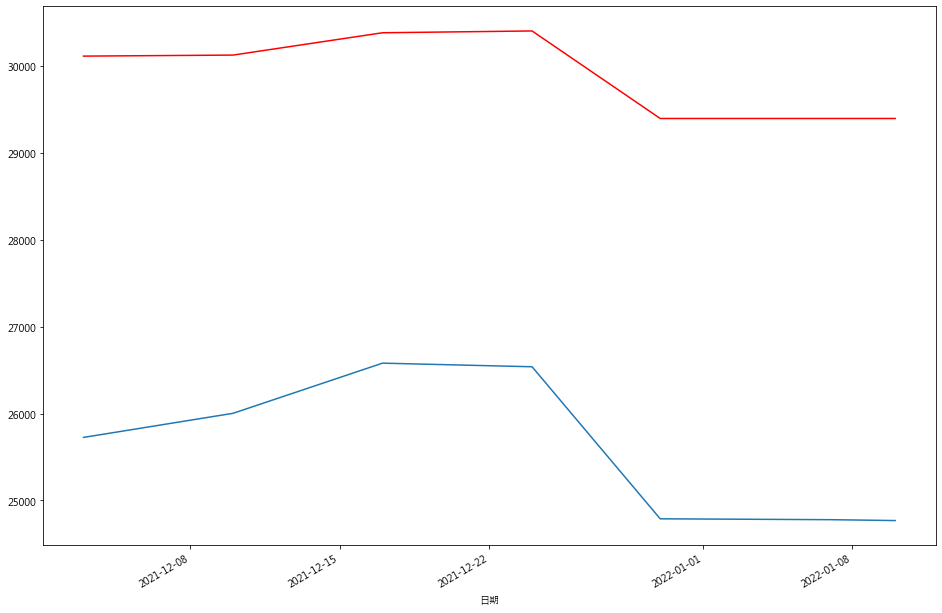

In [16]:
(p*1000)['2021-12':].plot(figsize=(16, 11))
px = (((bs * profit)*1000).sum(axis=1).cumsum() - (bs - bs.shift(1)).abs().sum(axis=1).cumsum() * 0.01)
px['2021-12':].plot(color='red')
plt.show()

In [93]:
tt = (((bs * profit).apply(prodprofit, axis=0).sum(axis=1) - (bs - bs.shift(1)).abs().sum(axis=1) * 0.01) / bs.sum(axis=1))

<AxesSubplot:xlabel='日期'>

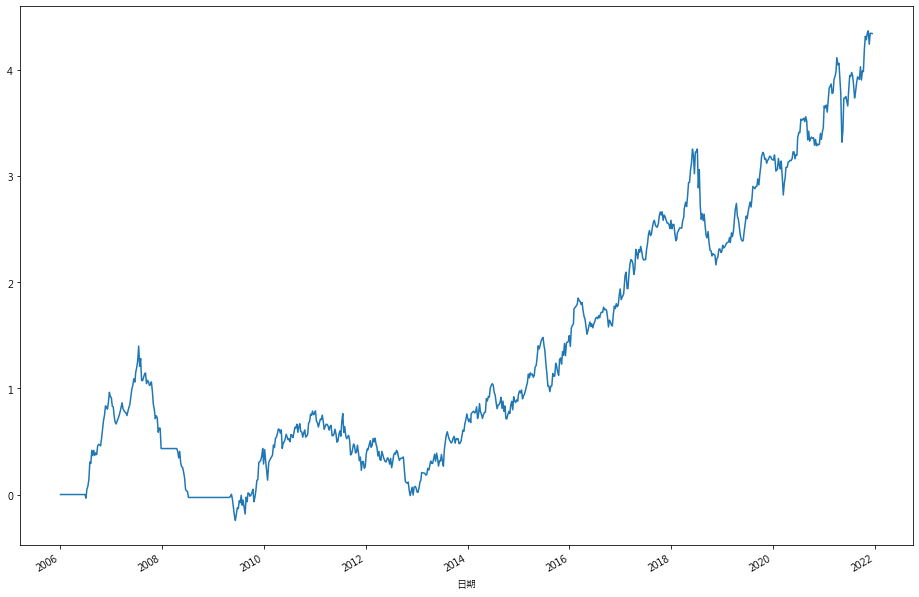

In [94]:
tt.replace([-np.inf, np.inf], 0).fillna(0).cumsum().plot(figsize=(16, 11))

In [27]:
from IPython.display import display
bs_daily = copy.deepcopy(adjopen_daily)
bs_daily.iloc[:] = np.nan
bs_daily.loc[bs.index, :] = bs
bs_daily = bs_daily.fillna(method='ffill').fillna(0)
display(bs_daily.head())
#bs_daily.to_csv(r'D:\BQuant Hackathon\ForBqnt.csv', encoding='big5')

,博大,信音,均華,鉅橡,禾伸堂,新鉅科,宏捷科,佳世達,尼克森,凌通,...,友威科,信昌電,佳邦,光頡,瑞軒,台燿,兆赫,永崴投控,晶睿,久威
日期,,,,,,,,,,,,,,,,,,,,,
2006-01-02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2006-01-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2006-01-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2006-01-05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2006-01-06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [28]:
#bs_daily.head()
stock_bq_map = {}
for k, v in stock_map.items():
    stock_bq_map[k] = str(v) +' TT Equity'
bs_daily.columns = bs_daily.columns.map(stock_bq_map)
bs_daily.index.name = 'DATE'
bs_daily = bs_daily.loc['2017':]
bs_daily.to_csv(r'D:\BQuant Hackathon\ForBqnt.csv')

In [96]:
le = 1

print('時間: ', bs.iloc[-le].name)
print('進場: ', bs.iloc[-le][(bs.iloc[-le]==1)&(bs.iloc[-le-1]==0)], '共 {} 檔'.format(bs.iloc[-le][(bs.iloc[-le]==1)&(bs.iloc[-le-1]==0)].sum()))
print('進場代號: ', bs.iloc[-le][(bs.iloc[-le]==1)&(bs.iloc[-le-1]==0)].index.map(stock_map))
print('出場: ', bs.iloc[-le][(bs.iloc[-le]==0)&(bs.iloc[-le-1]==1)], '共 {} 檔'.format(bs.iloc[-le][(bs.iloc[-le]==0)&(bs.iloc[-le-1]==1)].count()))
print('持倉: ', pd.DataFrame(list(zip(bs.iloc[-le][(bs.iloc[-le]==1)].index, \
                                    bs.iloc[-le][(bs.iloc[-le]==1)].index.map(stock_map), \
                                    entry_date.iloc[-le][(bs.iloc[-le]==1)].astype(str), \
                                    entry.iloc[-le][(bs.iloc[-le]==1)], \
                                    entry_type.iloc[-le][bs.iloc[-le]==1]))).sort_values(2),\
      '共 {} 檔'.format(bs.iloc[-le][(bs.iloc[-le]==1)].sum()))
print('最大持倉: ', bs[bs==1].sum(axis=1).max())
print('平均持倉: ', bs[bs==1].sum(axis=1).mean())
print('平均持倉時間: ', np.mean(hold_list))
print('MDD: {:.2f}  發生日期: {} RoR: {:.2f}'.format(mdd, mddt, ror))
print('------------------------------------------------------------------------------------------------')

時間:  2021-12-10 00:00:00
進場:  Series([], Name: 2021-12-10 00:00:00, dtype: float64) 共 0.0 檔
進場代號:  Index([], dtype='object')
出場:  力旺   0.00
Name: 2021-12-10 00:00:00, dtype: float64 共 1 檔
持倉:          0     1                    2        3    4
1      智原  3035  2021-05-28 00:00:00    66.94 1.00
4      德微  3675  2021-07-09 00:00:00   143.31 1.00
6      晶焱  6411  2021-10-01 00:00:00   198.00 1.00
2      晶宏  3141  2021-10-22 00:00:00   189.00 1.00
5  AES-KY  6781  2021-10-22 00:00:00 1,165.00 1.00
0      欣興  3037  2021-10-29 00:00:00   190.00 1.00
3      華擎  3515  2021-11-12 00:00:00   241.50 1.00 共 7.0 檔
最大持倉:  18.0
平均持倉:  5.146163215590743
平均持倉時間:  13.422077922077921
MDD: -11.82  發生日期: 2009-06-12 00:00:00 RoR: 2.10
------------------------------------------------------------------------------------------------


In [85]:
bs.to_csv(r'D:\Python相關\Report\Asharpe bs.csv')

In [64]:
bs.sum(axis=1).quantile(.75)

7.0

In [70]:
adjopen.index = adjclose.index
profit = adjopen.pct_change().shift(-2)
profit.loc[:, bs.loc['2021-4-23'][bs.loc['2021-4-23']>0].index].loc['2021-5-7'].mean()

-0.24070362952481011

In [97]:
le=1
print('持倉: ', pd.DataFrame(list(zip(bs.iloc[-le][(bs.iloc[-le]==1)].index, \
                                    bs.iloc[-le][(bs.iloc[-le]==1)].index.map(stock_map), \
                                    entry_date.iloc[-le][(bs.iloc[-le]==1)].astype(str), \
                                    entry.iloc[-le][(bs.iloc[-le]==1)], \
                                    entry_type.iloc[-le][bs.iloc[-le]==1])), columns=['商品名稱', '商品代號', '進場日期', '進場價格', '進場種類']).sort_values('進場日期'))

#((close.loc['2021-09-23', bs.iloc[-le][(bs.iloc[-le]==1)].index] - close.loc['2021-09-22', bs.iloc[-le][(bs.iloc[-le]==1)].index])/close.loc['2021-09-22', bs.iloc[-le][(bs.iloc[-le]==1)].index])\
#.mean()
pd.DataFrame(list(zip(bs.iloc[-le][(bs.iloc[-le]==1)].index, \
                                    bs.iloc[-le][(bs.iloc[-le]==1)].index.map(stock_map), \
                                    entry_date.iloc[-le][(bs.iloc[-le]==1)].astype(str), \
                                    entry.iloc[-le][(bs.iloc[-le]==1)], \
                                    entry_type.iloc[-le][bs.iloc[-le]==1])), columns=['商品名稱', '商品代號', '進場日期', '進場價格', '進場種類']).sort_values('進場日期')\
.to_excel(r'\\192.168.1.230\新金部\02策略\關鍵點\ASharpe'+datetime.datetime.today().strftime('%Y-%m-%d')+'.xlsx', index=False)


持倉:       商品名稱  商品代號                 進場日期     進場價格  進場種類
1      智原  3035  2021-05-28 00:00:00    66.94  1.00
4      德微  3675  2021-07-09 00:00:00   143.31  1.00
6      晶焱  6411  2021-10-01 00:00:00   198.00  1.00
2      晶宏  3141  2021-10-22 00:00:00   189.00  1.00
5  AES-KY  6781  2021-10-22 00:00:00 1,165.00  1.00
0      欣興  3037  2021-10-29 00:00:00   190.00  1.00
3      華擎  3515  2021-11-12 00:00:00   241.50  1.00


In [121]:
    bs_daily = copy.deepcopy(adjopen_daily)
    bs_daily.iloc[:] = np.nan
    bs_daily.loc[bs.index, :] = bs
    bs_daily = bs_daily.fillna(method='ffill').fillna(0)
    p_daily = ((bs_daily * profit_daily).sum(axis=1) - (bs_daily - bs_daily.shift(1)).abs().sum(axis=1) * 0.01) / bs_daily.sum(axis=1).replace(0, 1)

In [123]:
p_daily.cumsum()

日期
2006-01-02    0.00
2006-01-03    0.00
2006-01-04    0.00
2006-01-05    0.00
2006-01-06    0.00
2006-01-09    0.00
2006-01-10    0.00
2006-01-11    0.00
2006-01-12    0.00
2006-01-13    0.00
2006-01-16    0.00
2006-01-17    0.00
2006-01-18    0.00
2006-01-19    0.00
2006-01-20    0.00
2006-01-23    0.00
2006-01-24    0.00
2006-01-25    0.00
2006-02-03    0.00
2006-02-06    0.00
2006-02-07    0.00
2006-02-08    0.00
2006-02-09    0.00
2006-02-10    0.01
2006-02-13    0.01
2006-02-14    0.03
2006-02-15    0.02
2006-02-16    0.03
2006-02-17    0.05
2006-02-20    0.04
2006-02-21    0.01
2006-02-22    0.04
2006-02-23    0.09
2006-02-24    0.10
2006-02-27    0.13
2006-03-01    0.11
2006-03-02    0.09
2006-03-03    0.10
2006-03-06    0.10
2006-03-07    0.09
2006-03-08    0.09
2006-03-09    0.11
2006-03-10    0.12
2006-03-13    0.12
2006-03-14    0.14
2006-03-15    0.14
2006-03-16    0.18
2006-03-17    0.18
2006-03-20    0.11
2006-03-21    0.16
2006-03-22    0.12
2006-03-23    0.09
2006-03-2

In [26]:
bs.sum(axis=1)

日期
2006-01-06    0.00
2006-01-13    0.00
2006-01-20    0.00
2006-01-25    0.00
2006-02-03    0.00
2006-02-10    0.00
2006-02-17    0.00
2006-02-24    0.00
2006-03-03    0.00
2006-03-10    0.00
2006-03-17    0.00
2006-03-24    0.00
2006-03-31    0.00
2006-04-07    0.00
2006-04-14    0.00
2006-04-21    0.00
2006-04-28    0.00
2006-05-05    0.00
2006-05-12    0.00
2006-05-19    0.00
2006-05-26    0.00
2006-06-02    0.00
2006-06-09    0.00
2006-06-16    0.00
2006-06-23    0.00
2006-06-30    0.00
2006-07-07    1.00
2006-07-14    1.00
2006-07-21    1.00
2006-07-28    2.00
2006-08-04    2.00
2006-08-11    3.00
2006-08-18    3.00
2006-08-25    3.00
2006-09-01    4.00
2006-09-08    5.00
2006-09-15    6.00
2006-09-22    6.00
2006-09-29    5.00
2006-10-05    5.00
2006-10-14    4.00
2006-10-20    5.00
2006-10-27    6.00
2006-11-03    6.00
2006-11-10    7.00
2006-11-17    7.00
2006-11-24    6.00
2006-12-01    6.00
2006-12-08    6.00
2006-12-15    7.00
2006-12-22    6.00
2006-12-29    6.00
2007-01-0

In [7]:
invest = load_mongo('投信持股比率')

In [18]:
def nlarge(se):
    return se.nlargest(10).sum()
def nsmall(se):
    return se.nsmallest(10).sum()

In [12]:
invest.iloc[1].nlargest(10).sum()

179.24999999999997

In [23]:
invest = load_mongo('投信持股比率')
twse = pd.DataFrame(list(db['指數調整收盤價'].find({}))).drop('_id', axis=1)
twse.set_index('日期', inplace=True)
invest_large = (invest - invest.shift(1)).apply(nlarge, axis=1)
invest_small = (invest - invest.shift(1)).apply(nsmall, axis=1)


In [31]:
txf = pd.concat([twse, (invest_large+invest_small)], axis=1)

<AxesSubplot:xlabel='日期'>

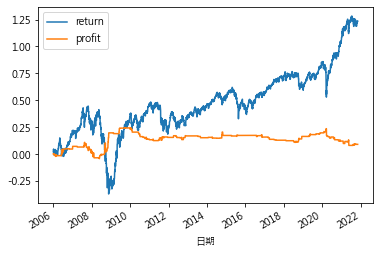

In [49]:
txf['bs'] = np.where(txf[0] < -3, -1, 0)
txf['return'] = txf['加權指數'].pct_change().shift(-1)
txf['profit'] = txf['bs'] * txf['return']
txf[['return', 'profit']].cumsum().plot()

In [50]:
pd.DataFrame.apply?

Signature:
pd.DataFrame.apply(
    self,
    func,
    axis=0,
    raw=False,
    result_type=None,
    args=(),
    **kwds,
)
Docstring:
Apply a function along an axis of the DataFrame.

Objects passed to the function are Series objects whose index is
either the DataFrame's index (``axis=0``) or the DataFrame's columns
(``axis=1``). By default (``result_type=None``), the final return type
is inferred from the return type of the applied function. Otherwise,
it depends on the `result_type` argument.

Parameters
----------
func : function
    Function to apply to each column or row.
axis : {0 or 'index', 1 or 'columns'}, default 0
    Axis along which the function is applied:

    * 0 or 'index': apply function to each column.
    * 1 or 'columns': apply function to each row.

raw : bool, default False
    Determines if row or column is passed as a Series or ndarray object:

    * ``False`` : passes each row or column as a Series to the
      function.
    * ``True`` : the passed functio